In [47]:
pip install tensorflow

In [48]:
import os
import shutil
import pathlib
import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


In [49]:
# Fetch and prepare the IMDB dataset
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -O imdb_dataset.tar.gz
!tar -xzf imdb_dataset.tar.gz
!rm -rf aclImdb/train/unsup


--2025-04-08 16:55:27--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘imdb_dataset.tar.gz’

imdb_dataset.tar.gz 100%[===================>]  80.23M  20.7MB/s    in 4.4s    

2025-04-08 16:55:32 (18.1 MB/s) - ‘imdb_dataset.tar.gz’ saved [84125825/84125825]



In [50]:
import os

def review_summary(directory="aclImdb", max_files=5):
    for dataset_type in ["train", "test"]:
        print(f"\nDataset Type: '{dataset_type}'")
        for label in ["pos", "neg"]:
            print(f"  Review Type: {label}")
            dir_path = os.path.join(directory, dataset_type, label)
            file_list = os.listdir(dir_path)[:max_files]
            for idx, review_file in enumerate(file_list):
                review_path = os.path.join(dir_path, review_file)
                with open(review_path, "r", encoding="utf-8") as review:
                    lines = review.readlines()
                print(f"\n  Review {idx + 1}: {review_file}")
                print(f"    Total Lines: {len(lines)}")
                print(f"    Preview (up to 5 lines):")
                print("    " + "\n    ".join(lines[:5]).strip())


In [51]:
review_summary(directory="aclImdb", max_files=5)



Dataset Type: 'train'
  Review Type: pos

  Review 1: 7880_8.txt
    Total Lines: 1
    Preview (up to 5 lines):
    The plot of this enjoyable MGM musical is contrived and only occasionally amusing, dealing with espionage and romance but the focus of the film is properly pointed upon the tuneful interludes showcasing the enormously talented and athletic tap dancing Eleanor Powell, abetted by Tommy Dorsey and his orchestra, featuring Ziggy Elman, Buddy Rich and Frank Sinatra. Red Skelton shares top billing with Powell, and he and sidekick Bert Lahr are given most of the comedic minutes, although Skelton is more effective when he, if it can be believed, performs as Powell's love interest, with Virginia O'Brien actually providing most of the film's humor as the dancer's companion. The technical brilliance of Powell is evidenced during one incredible scene within which Buddy Rich contributes his drumming skills, and which must be viewed several times in order to permit one's breathing to

In [52]:
# Set up dataset folders
batch_sz = 32
root_path = pathlib.Path("aclImdb")
validation_path = root_path / "val"
training_path = root_path / "train"

for label in ("neg", "pos"):
    os.makedirs(validation_path / label, exist_ok=True)
    file_names = os.listdir(training_path / label)
    rnd = random.Random(1337)
    rnd.shuffle(file_names)
    val_count = int(0.2 * len(file_names))
    selected_for_val = file_names[-val_count:]

    for file in selected_for_val:
        src = training_path / label / file
        dest = validation_path / label / file
        if not os.path.exists(dest):
            shutil.move(src, dest)


In [53]:
# Load IMDB dataset splits
train_data = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_sz
)

validation_data = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_sz
)

test_data = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_sz
)

text_only_train = train_data.map(lambda text, label: text)


Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [54]:
# Define tokenization settings
seq_len = 150
vocab_limit = 10000
tokenizer = layers.TextVectorization(
    max_tokens=vocab_limit,
    output_mode="int",
    output_sequence_length=seq_len,
)

tokenizer.adapt(text_only_train)



In [55]:
# Tokenize the datasets
encoded_train_ds = train_data.map(
    lambda text, label: (tokenizer(text), label),
    num_parallel_calls=4).take(100)  # Limit to 100 training samples

encoded_val_ds = validation_data.map(
    lambda text, label: (tokenizer(text), label),
    num_parallel_calls=4).take(10000)  # Limit to 10,000 validation samples

encoded_test_ds = test_data.map(
    lambda text, label: (tokenizer(text), label),
    num_parallel_calls=4)


In [56]:
# Model with embedding and LSTM layers
input_layer = tf.keras.Input(shape=(None,), dtype="int64")
embedded_layer = layers.Embedding(input_dim=vocab_limit, output_dim=128)(input_layer)
encoded_output = layers.Bidirectional(layers.LSTM(32))(embedded_layer)
dropout_layer = layers.Dropout(0.2)(encoded_output)
output_layer = layers.Dense(1, activation="sigmoid")(dropout_layer)

embedding_model = tf.keras.Model(input_layer, output_layer)

embedding_model.compile(optimizer="rmsprop",
                        loss="binary_crossentropy",
                        metrics=["accuracy"])

embedding_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint("embedding_model.keras", save_best_only=True)
]


In [58]:
checkpoint_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_embedding_model.keras", save_best_only=True)
]


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.5270 - loss: 0.6920 - val_accuracy: 0.6128 - val_loss: 0.6667
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.6359 - loss: 0.6423 - val_accuracy: 0.7410 - val_loss: 0.5615
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.7834 - loss: 0.4964 - val_accuracy: 0.7872 - val_loss: 0.4745
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.8451 - loss: 0.3807 - val_accuracy: 0.8114 - val_loss: 0.4286
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.8800 - loss: 0.3172 - val_accuracy: 0.8040 - val_loss: 0.4255
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9092 - loss: 0.2555 - val_accuracy: 0.7414 - val_loss: 0.5901
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9311 - loss: 0.2004 - val_accuracy: 0.8178 - val_loss: 0.4241
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9491 - loss: 0.1567 - val_acc

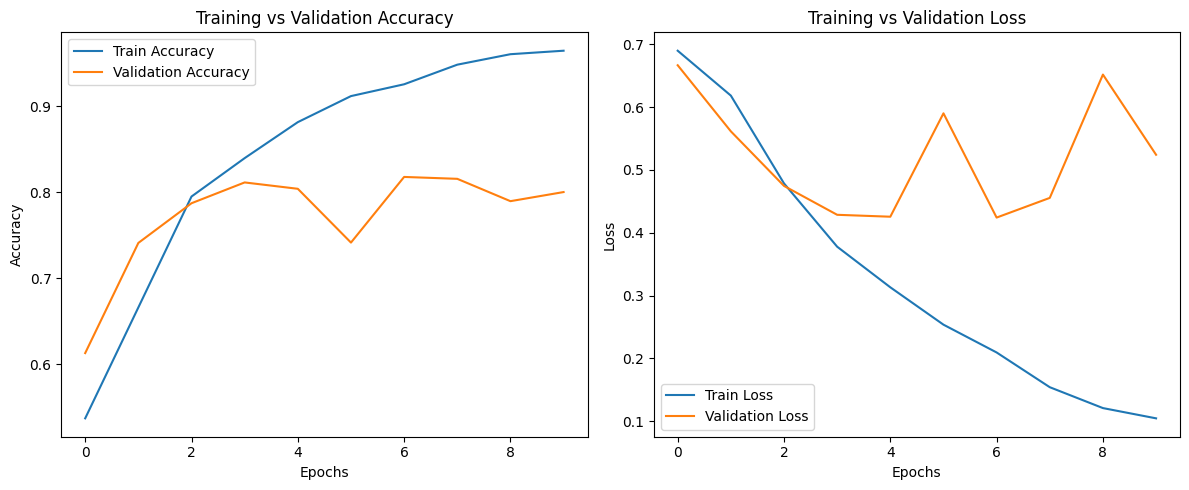

In [59]:
import matplotlib.pyplot as plt

# Fit the model and store the training history
history_embedded = embedding_model.fit(
    encoded_train_ds,
    validation_data=encoded_val_ds,
    epochs=10,  # Adjust the number of epochs as needed
    callbacks=checkpoint_callbacks  # Or callbacks_list, if preferred
)

# Extract the training history
train_history = history_embedded.history

# Plot training and validation performance
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(train_history['accuracy'], label='Train Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(train_history['loss'], label='Train Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Download and extract GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip -O glove_embeddings.zip
!unzip -q glove_embeddings.zip


--2025-04-08 16:57:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 16:57:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 16:57:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove_embeddings.zi

In [ ]:
# Prepare the GloVe embedding matrix
embedding_dim = 100
glove_file_path = "glove.6B.100d.txt"

embeddings_dict = {}
with open(glove_file_path) as f:
    for line in f:
        word, coefficients = line.split(maxsplit=1)
        coefficients = np.fromstring(coefficients, "f", sep=" ")
        embeddings_dict[word] = coefficients

vocab_list = tokenizer.get_vocabulary()
word_to_idx = dict(zip(vocab_list, range(len(vocab_list))))

embedding_matrix = np.zeros((vocab_limit, embedding_dim))
for word, index in word_to_idx.items():
    if index < vocab_limit:
        vector = embeddings_dict.get(word)
        if vector is not None:
            embedding_matrix[index] = vector


In [ ]:
# Pretrained embedding layer model
embedding_layer = layers.Embedding(
    vocab_limit,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

input_layer = tf.keras.Input(shape=(None,), dtype="int64")
embedded_output = embedding_layer(input_layer)
encoded_output = layers.Bidirectional(layers.LSTM(32))(embedded_output)
dropout_layer = layers.Dropout(0.2)(encoded_output)
output_layer = layers.Dense(1, activation="sigmoid")(dropout_layer)

pretrained_embedding_model = tf.keras.Model(input_layer, output_layer)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as l # Import layers and assign alias 'l'

input_layer = tf.keras.Input(shape=(None,), dtype="int64")
embedded_output = embedding_layer(input_layer)
encoded_output = l.Bidirectional(l.LSTM(32))(embedded_output)
dropout_layer = l.Dropout(0.2)(encoded_output)
output_layer = l.Dense(1, activation="sigmoid")(dropout_layer)

pretrained_model = tf.keras.Model(input_layer, output_layer)

pretrained_model.compile(optimizer="rmsprop",
                         loss="binary_crossentropy",
                         metrics=["accuracy"])

pretrained_model.summary()

In [ ]:
training_callbacks = [
    keras.callbacks.ModelCheckpoint("pretrained_lstm_model.keras", save_best_only=True)
]

training_history = pretrained_model.fit(
    encoded_train_ds,
    validation_data=encoded_val_ds,
    epochs=10,
    callbacks=training_callbacks
)

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
metrics = training_history.history # Changed from history_pretrained to training_history

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(metrics['accuracy'], label='Train Accuracy', marker='o')
plt.plot(metrics['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(metrics['loss'], label='Train Loss', marker='o')
plt.plot(metrics['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define training sizes
sample_sizes = [100, 200, 500, 1000]
embed_accs = []
pretrained_accs = []

# Setup plot
plt.figure(figsize=(12, 6))
plt.title('Model Accuracy vs. Training Sample Sizes')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.grid(True)

# Iterate through each sample size
for size in sample_sizes:
    print(f"\n### Training with {size} samples ###")

    # Prepare dataset of current sample size
    limited_train_ds = train_data.take(size)
    # Tokenize the limited dataset
    limited_encoded_train_ds = limited_train_ds.map(lambda text, label: (tokenizer(text), label))


    # Train custom embedding model
    print("→ Training Custom Embedding Model")
    embedding_model.fit(limited_encoded_train_ds, validation_data=encoded_val_ds, epochs=10, verbose=0)
    acc_embed = embedding_model.evaluate(encoded_test_ds, verbose=0)[1]
    embed_accs.append(acc_embed)
    print(f"Custom Embedding Accuracy: {acc_embed:.4f}")

    # Train pretrained embedding model
    print("→ Training Pretrained Embedding Model")
    pretrained_model.fit(limited_encoded_train_ds, validation_data=encoded_val_ds, epochs=10, verbose=0)
    acc_pretrained = pretrained_model.evaluate(encoded_test_ds, verbose=0)[1]
    pretrained_accs.append(acc_pretrained)
    print(f"Pretrained Embedding Accuracy: {acc_pretrained:.4f}")

# Plot final results
plt.plot(sample_sizes, embed_accs, marker='o', label='Custom Embedding', color='royalblue')
plt.plot(sample_sizes, pretrained_accs, marker='s', label='Pretrained Embedding', color='darkorange')
plt.xticks(sample_sizes)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Combine results into a single DataFrame
summary_df = pd.DataFrame({
    "Sample Size": sample_sizes,
    "Custom Embedding Accuracy": embedding_accuracies,
    "Pretrained Embedding Accuracy": pretrained_accuracies
})

# Display summary table
print("\n=== Model Accuracy Summary ===")
print(summary_df.to_string(index=False))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define model names and final validation accuracies
models = ['Custom Embedding', 'Pretrained Embedding']
final_val_accuracies = [
    history_embedded.history['val_accuracy'][-1],
    history_pretrained.history['val_accuracy'][-1]
]

# Create bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, final_val_accuracies, color=['mediumseagreen', 'gold'], width=0.6)

# Add labels and title
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Comparison of Final Validation Accuracy', fontsize=14)

# Annotate bars with accuracy values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
sample_sizes = [100, 200, 500, 1000]
embedding_accuracies = [0.75280, 0.77556, 0.80652, 0.81772]
pretrained_accuracies = [0.78072, 0.80588, 0.81868, 0.82456]

# Setup
bar_width = 0.25
x = np.arange(len(sample_sizes))

# Plot
plt.figure(figsize=(10, 6))

# Bars
bars1 = plt.bar(x - bar_width/2, embedding_accuracies, width=bar_width,
                color='cornflowerblue', label='Custom Embedding')
bars2 = plt.bar(x + bar_width/2, pretrained_accuracies, width=bar_width,
                color='gold', label='Pretrained Embedding')

# Lines
plt.plot(x - bar_width/2, embedding_accuracies, marker='o',
         color='blue', linestyle='--', label='Custom Embedding (Line)')
plt.plot(x + bar_width/2, pretrained_accuracies, marker='o',
         color='darkorange', linestyle='--', label='Pretrained Embedding (Line)')

# Labels & title
plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Final Test Accuracy vs. Training Sample Size', fontsize=14)
plt.xticks(x, sample_sizes)
plt.ylim(0.7, 0.85)
plt.legend()

# Annotate values
for i in range(len(sample_sizes)):
    plt.text(x[i] - bar_width/2, embedding_accuracies[i] + 0.003,
             f'{embedding_accuracies[i]:.4f}', ha='center', fontsize=10)
    plt.text(x[i] + bar_width/2, pretrained_accuracies[i] + 0.003,
             f'{pretrained_accuracies[i]:.4f}', ha='center', fontsize=10)

# Final touches
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()
